In [1]:
import requests
import pandas as pd
from bs4 import BeautifulSoup
import seaborn as sns
import numpy as np

In [2]:
def get_table_data(url, table_class):
    # GET the webpage using requests
    page = requests.get(url)
    if page.status_code == 200:
        soup = BeautifulSoup(page.content, 'html.parser')
        data_table = soup.find("table", {"class": table_class})
        
        # Read the headers from the table
        header_data = data_table.thead.findAll('tr')[0]
        headers = [th.a.text for th in header_data.findAll('th')]
        
        # Read the rows from the table
        row_data = data_table.findAll('tbody')[0].findAll('tr')
        rows = [[td.get_text().strip() for td in tr.findAll('td')] for tr in row_data]
        
        # Return a tuple of headers and rows
        return headers, rows
    
    return None, None

In [3]:
# This will read the list of states and its population from a table
states_header, states_data = get_table_data("https://worldpopulationreview.com/states", 'jsx-2006211681')

In [4]:
# Parse the table data and store the state names in a list
states = [data[1].replace(" ", "-").lower() for data in states_data]
states = states + ['district-of-columbia', 'puerto-rico', 'nebraska', 'texas']
len(states)

54

In [5]:
all_rows = []

# Zipcodes are listed by state. We iterate through each state to read the table and store append the data to the list
for state in states:
   headers, rows = get_table_data(f"https://worldpopulationreview.com/zips/{state}", 'jsx-2567515043')
   all_rows = all_rows + rows

In [6]:
# Loading the rows and headers to a dataframe
df = pd.DataFrame(all_rows, columns=headers)

In [7]:
df

,Zip Code,City,County,Population
0,90011,Los Angeles,Los Angeles County,"111,165"
1,91331,Pacoima,Los Angeles County,"105,458"
2,90650,Norwalk,Los Angeles County,"105,304"
3,90201,Bell,Los Angeles County,"101,965"
4,90044,Los Angeles,Los Angeles County,"99,443"
...,...,...,...,...
35376,79051,Kerrick,Dallam County,
35377,79058,Masterson,Moore County,
35378,79105,Amarillo,Potter County,
35379,79759,Notrees,Ector County,


### Step 1. Removing white spaces from column names

Column names have unwanted spaces. Lets remove the extra spaces from the data

In [8]:
df.columns

Index(['Zip Code  ', 'City  ', 'County  ', 'Population  '], dtype='object')

In [9]:
df.columns = df.columns.str.replace(' ','')
df.columns

Index(['ZipCode', 'City', 'County', 'Population'], dtype='object')

### Step 2. Converting Population from str to int

Population data is in str type. Lets convert it to int

In [10]:
df['Population'] = df['Population'].str.replace(',','')
df['Population'] = df['Population'].replace(r'^\s*$', 0, regex=True)
df['Population'] = df['Population'].astype(int)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35381 entries, 0 to 35380
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   ZipCode     35381 non-null  object
 1   City        35381 non-null  object
 2   County      35381 non-null  object
 3   Population  35381 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 1.1+ MB


### Step 3. Finding the missing values and filling

Lets check for missing values and fill it with median of Population data

In [12]:
df.isnull().sum()

ZipCode       0
City          0
County        0
Population    0
dtype: int64

In [13]:
# missing values were filled with 0 earlier. Lets use median of population to fill the missing data
df[df.Population == 0] = np.nan
df.fillna(df['Population'].median(), inplace=True)

### Step 4. Drop duplicate data

Now let's check for duplicate rows and remove them.

In [14]:
df.duplicated().sum()

2851

In [15]:
# Removing 2510 duplicates found
df.drop_duplicates(inplace = True)

In [16]:
df.duplicated().sum()

0

In [17]:
df.describe()

,Population
count,32530.000000
mean,9941.839948
std,14744.692317
min,1.000000
25%,732.000000
50%,2849.000000
75%,13479.000000
max,128294.000000


### Step 5. Ouliers

<AxesSubplot:xlabel='Population'>

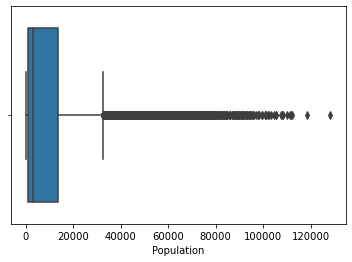

In [18]:
sns.boxplot(x=df['Population'])

In [19]:
df.describe()

,Population
count,32530.000000
mean,9941.839948
std,14744.692317
min,1.000000
25%,732.000000
50%,2849.000000
75%,13479.000000
max,128294.000000


This is a population data. Some zip codes might have high population density. There is no outlier in this data